In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import warnings
import os
warnings.filterwarnings('ignore')

In [3]:
sns.set()
# 设置seaborn的样式
sns.set_style("whitegrid")
sns.set_context('talk')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set(font='SimHei')

In [7]:
def reduce_mem_usage(df):
    """
    调整数据类型，减少数据在内存中的占用
    """
    start_mem = df.memory_usage().sum()
    print(f"Memory usage of dataframe is {start_mem}MB")

    # 根据每一列的最大值和最小值来调整每一列的数据类型
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_men = df.memory_usage().sum()
    print(f"Memory usage after adjust is {end_men}MB")
    print(f"Memory usage decreased by {100*(start_mem-end_men)/start_mem}%")
    return df

In [9]:
data = pd.read_csv("train.csv")
train_data = reduce_mem_usage(data)
data = pd.read_csv("testA.csv")
test_data = reduce_mem_usage(data)

Memory usage of dataframe is 300800128MB
Memory usage after adjust is 72829816MB
Memory usage decreased by 75.7879704093743%
Memory usage of dataframe is 73600128MB
Memory usage after adjust is 18029392MB
Memory usage decreased by 75.50358608071986%


### Baseline模型
+ 特征工程 主要处理缺失值、特征类型转换和编码 使用树模型异常值和缺失值不需要处理
+ K折交叉验证+LightGBM
+ 评分标准为AUC

In [13]:
print(f"训练集大小:{train_data.shape}")
print(f"测试机大小:{test_data.shape}")
print("*"*50)
print(train_data.info())
print("*"*50)
print(train_data.describe())
print("*"*50)
nullRate = train_data.isnull().sum() / train_data.shape[0]
print(nullRate)

训练集大小:(800000, 47)
测试机大小:(200000, 46)
**************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   id                  800000 non-null  int32   
 1   loanAmnt            800000 non-null  float16 
 2   term                800000 non-null  int8    
 3   interestRate        800000 non-null  float16 
 4   installment         800000 non-null  float16 
 5   grade               800000 non-null  category
 6   subGrade            800000 non-null  category
 7   employmentTitle     799999 non-null  float32 
 8   employmentLength    753201 non-null  category
 9   homeOwnership       800000 non-null  int8    
 10  annualIncome        800000 non-null  float32 
 11  verificationStatus  800000 non-null  int8    
 12  issueDate           800000 non-null  category
 13  isDefault           800000 non

In [20]:
numerical_feature = list(train_data.select_dtypes(exclude=['category']).columns)
category_feature = list(filter(lambda  x : x not in numerical_feature, list(train_data.columns)))
label = "isDefault"
numerical_feature.remove(label)

In [22]:
print(f"数值型变量个数:{len(numerical_feature)}")
print(f"分类型变量个数:{len(category_feature)}")
train_data.isnull().sum()

数值型变量个数:41
分类型变量个数:5


id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           1
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  1
regionCode                0
dti                     239
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies      405
revolBal                  0
revolUtil               531
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     1
policyCode                0
n0                    40270
n1                    40270
n2                    40270
n3                  

In [23]:
train_data[numerical_feature] = train_data[numerical_feature].fillna(train_data[numerical_feature].median())
test_data[numerical_feature] = test_data[numerical_feature].fillna(test_data[numerical_feature].median())
train_data[category_feature] = train_data[category_feature].fillna(train_data[category_feature].mode())
test_data[category_feature] = test_data[category_feature].fillna(test_data[category_feature].mode())

In [24]:
train_data.isnull().sum()

id                        0
loanAmnt                  0
term                      0
interestRate              0
installment               0
grade                     0
subGrade                  0
employmentTitle           0
employmentLength      46799
homeOwnership             0
annualIncome              0
verificationStatus        0
issueDate                 0
isDefault                 0
purpose                   0
postCode                  0
regionCode                0
dti                       0
delinquency_2years        0
ficoRangeLow              0
ficoRangeHigh             0
openAcc                   0
pubRec                    0
pubRecBankruptcies        0
revolBal                  0
revolUtil                 0
totalAcc                  0
initialListStatus         0
applicationType           0
earliesCreditLine         0
title                     0
policyCode                0
n0                        0
n1                        0
n2                        0
n3                  

In [25]:
# 针对分类型变量进行逐个处理
category_feature

['grade', 'subGrade', 'employmentLength', 'issueDate', 'earliesCreditLine']

In [28]:
for data in [train_data,test_data]:
    data['issueDate'] = pd.to_datetime(data['issueDate'],format="%Y-%m-%d")
    startDate = datetime.datetime.strptime("2020-1-01","%Y-%m-%d")
    data["issueDateDT"] = data['issueDate'].apply(lambda x: x-startDate).dt.days

In [29]:
train_data['employmentLength'].value_counts().sort_index()

1 year        52489
10+ years    262753
2 years       72358
3 years       64152
4 years       47985
5 years       50102
6 years       37254
7 years       35407
8 years       36192
9 years       30272
< 1 year      64237
Name: employmentLength, dtype: int64

In [30]:
def employmentLength_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split(" ")[0])

# 将对象类型转换为数值类型
for data in [train_data,test_data]:
    data['employmentLength'].replace(to_replace="10+ years",value="10 years",inplace=True)
    data['employmentLength'].replace(to_replace="< 1 year",value="0 years",inplace=True)
    data['employmentLength'] = data['employmentLength'].apply(employmentLength_to_int)

In [31]:
train_data["employmentLength"].value_counts().sort_index()

1      52489
10    262753
2      72358
3      64152
4      47985
5      50102
6      37254
7      35407
8      36192
9      30272
0      64237
Name: employmentLength, dtype: int64

In [32]:
train_data['earliesCreditLine'].value_counts().sort_index()

Apr-1955       2
Apr-1958       1
Apr-1960       2
Apr-1961       4
Apr-1962       4
            ... 
Sep-2011    1008
Sep-2012     575
Sep-2013     278
Sep-2014     104
Sep-2015       3
Name: earliesCreditLine, Length: 720, dtype: int64

In [33]:
for data in [train_data,test_data]:
    data['earliesCreditLine'] = data['earliesCreditLine'].apply(lambda s : s[-4:])

In [34]:
train_data['earliesCreditLine'].value_counts().sort_index()

1944       1
1946       2
1950       5
1951       7
1952       6
        ... 
2011    9792
2012    6628
2013    3525
2014    1475
2015     201
Name: earliesCreditLine, Length: 68, dtype: int64

In [35]:
cate_features = ["grade","subGrade","employmentTitle","homeOwnership","verificationStatus",
                 "purpose","postCode","regionCode","applicationType","initialListStatus","title","policyCode"]

for f in cate_features:
    print(f"{f}特征，类别数目:{data[f].nunique()}")

grade特征，类别数目:7
subGrade特征，类别数目:35
employmentTitle特征，类别数目:79282
homeOwnership特征，类别数目:6
verificationStatus特征，类别数目:3
purpose特征，类别数目:14
postCode特征，类别数目:889
regionCode特征，类别数目:51
applicationType特征，类别数目:2
initialListStatus特征，类别数目:2
title特征，类别数目:4831
policyCode特征，类别数目:1


In [36]:
train_data["grade"].value_counts().sort_index()

A    139661
B    233690
C    227118
D    119453
E     55661
F     19053
G      5364
Name: grade, dtype: int64

In [37]:
for data in [train_data,test_data]:
    data['grade'] = data['grade'].map({"A":1,"B":2,"C":3,"D":4,"E":5,"F":6,"G":7})

In [38]:
train_data['grade'].value_counts().sort_index()

1    139661
2    233690
3    227118
4    119453
5     55661
6     19053
7      5364
Name: grade, dtype: int64

In [39]:
for data in [train_data,test_data]:
    data = pd.get_dummies(data,columns=["subGrade","homeOwnership","verificationStatus","purpose","regionCode"],drop_first=True)

In [40]:
train_data

,id,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,...,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT
0,0,35008.0,5,19.515625,918.0000,5,E2,320.0,2,2,...,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,-2010
1,1,18000.0,5,18.484375,462.0000,4,D2,219843.0,5,0,...,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,-2709
2,2,12000.0,5,16.984375,298.2500,4,D3,31698.0,8,0,...,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,-1553
3,3,11000.0,3,7.261719,341.0000,1,A4,46854.0,10,1,...,4.0,7.0,21.0,6.0,9.0,0.0,0.0,0.0,1.0,-1614
4,4,3000.0,3,12.992188,101.0625,3,C2,54.0,NaN,1,...,9.0,10.0,15.0,7.0,12.0,0.0,0.0,0.0,4.0,-1401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,799995,24992.0,3,14.492188,860.5000,3,C4,2659.0,7,1,...,2.0,12.0,13.0,10.0,14.0,0.0,0.0,0.0,3.0,-1279
799996,799996,16992.0,3,7.898438,532.0000,1,A4,29205.0,10,0,...,16.0,2.0,19.0,2.0,7.0,0.0,0.0,0.0,0.0,-2466
799997,799997,6000.0,3,13.328125,203.1250,3,C3,2582.0,10,1,...,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0,-1553
799998,799998,19200.0,3,6.921875,592.0000,1,A4,151.0,10,0,...,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0,-1795


In [44]:
for col in tqdm(['employmentTitle','postCode','title','subGrade']):
    le = LabelEncoder()
    le.fit(list(train_data[col].astype(str).values) + list(test_data[col].astype(str).values))
    train_data[col] = le.transform(list(train_data[col].astype(str).values))
    test_data[col] = le.transform(list(test_data[col].astype(str).values))
print("Label Encoding编码完成")

100%|██████████| 4/4 [00:05<00:00,  1.36s/it]

Label Encoding编码完成


In [45]:
# 删除无效特征
for data in [train_data,test_data]:
    data.drop(['issueDate','id'],axis=1,inplace=True)

In [46]:
train_data.head(3).append(train_data.tail(3))

C:\Users\22806\AppData\Local\Temp\ipykernel_102596\2917352070.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data.head(3).append(train_data.tail(3))


,loanAmnt,term,interestRate,installment,grade,subGrade,employmentTitle,employmentLength,homeOwnership,annualIncome,...,n6,n7,n8,n9,n10,n11,n12,n13,n14,issueDateDT
0,35008.0,5,19.515625,918.000,5,21,192025,2,2,110000.0,...,8.0,4.0,12.0,2.0,7.0,0.0,0.0,0.0,2.0,-2010
1,18000.0,5,18.484375,462.000,4,16,104733,5,0,46000.0,...,7.0,7.0,13.0,5.0,13.0,0.0,0.0,0.0,2.0,-2709
2,12000.0,5,16.984375,298.250,4,17,189509,8,0,74000.0,...,21.0,4.0,5.0,3.0,11.0,0.0,0.0,0.0,4.0,-1553
799997,6000.0,3,13.328125,203.125,3,12,138795,10,1,65000.0,...,26.0,4.0,10.0,4.0,5.0,0.0,0.0,1.0,4.0,-1553
799998,19200.0,3,6.921875,592.000,1,3,45602,10,0,96000.0,...,6.0,12.0,22.0,8.0,16.0,0.0,0.0,0.0,5.0,-1795
799999,9000.0,3,11.062500,295.000,2,7,27055,5,0,120000.0,...,4.0,4.0,8.0,3.0,7.0,0.0,0.0,0.0,2.0,-518


In [59]:
feature_name = list(train_data.columns)
feature_name.remove('isDefault')
feature_name.remove('earliesCreditLine')
label = 'isDefault'
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 46 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   loanAmnt            800000 non-null  float16 
 1   term                800000 non-null  int8    
 2   interestRate        800000 non-null  float16 
 3   installment         800000 non-null  float16 
 4   grade               800000 non-null  category
 5   subGrade            800000 non-null  int32   
 6   employmentTitle     800000 non-null  int32   
 7   employmentLength    753201 non-null  category
 8   homeOwnership       800000 non-null  int8    
 9   annualIncome        800000 non-null  float32 
 10  verificationStatus  800000 non-null  int8    
 11  isDefault           800000 non-null  int8    
 12  purpose             800000 non-null  int8    
 13  postCode            800000 non-null  int32   
 14  regionCode          800000 non-null  int8    
 15  dti              

In [64]:
train_features = train_data[feature_name]
train_label = train_data[label]
test_features = test_data[feature_name]
print(f"训练特征:{train_features.shape}")
print(f"训练标签:{train_label.shape}")
print(f"测试特征:{test_features.shape}")

训练特征:(800000, 44)
训练标签:(800000,)
测试特征:(200000, 44)


In [65]:
# 划分数据集并且转换成LightGBM需要的形式
train_x,valid_x,train_y,valid_y = train_test_split(train_features,train_label,test_size=0.2)
train_matrix = lgb.Dataset(train_x,label=train_y)
valid_matrix = lgb.Dataset(valid_x,label=valid_y)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'learning_rate': 0.1,
            'metric': 'auc',
            'min_child_weight': 1e-3,
            'num_leaves': 31,
            'max_depth': -1,
            'reg_lambda': 0,
            'reg_alpha': 0,
            'feature_fraction': 1,
            'bagging_fraction': 1,
            'bagging_freq': 0,
            'seed': 2020,
            'nthread': 8,
            'verbose': -1,
}

model = lgb.train(params,train_set=train_matrix,valid_sets=valid_matrix,num_boost_round=20000,verbose_eval=1000,early_stopping_rounds=200)

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[510]	valid_0's auc: 0.733045


未调参lightgbm单模型在验证集上的AUC:0.7330452996327753


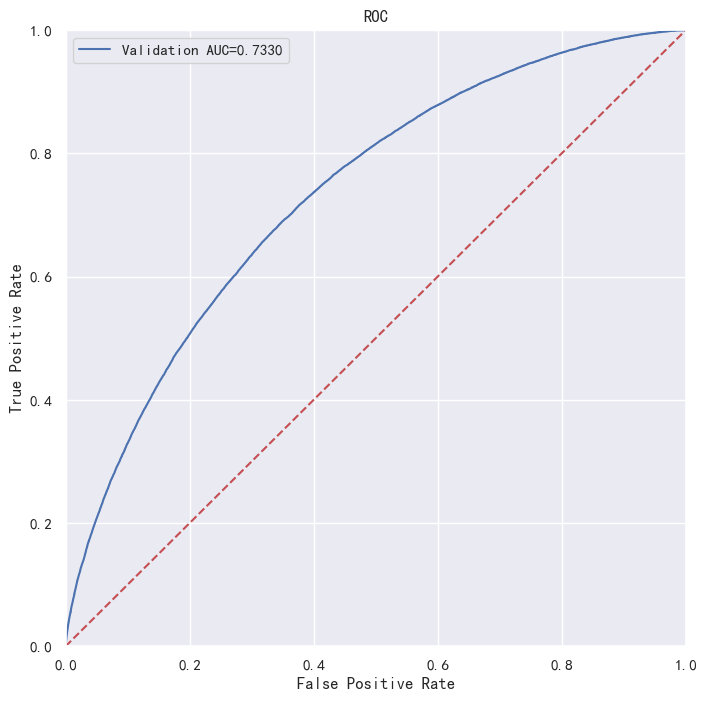

In [67]:
valid_predict = model.predict(valid_x,num_iteration=model.best_iteration)
fpr,tpr,threshold = roc_curve(valid_y,valid_predict)
roc_acu = auc(fpr,tpr)
print(f"未调参lightgbm单模型在验证集上的AUC:{roc_acu}")
# 画ROC曲线图
plt.figure(figsize=(8,8))
plt.title("Validation ROC")
plt.plot(fpr,tpr,'b',label="Validation AUC=%0.4f"%roc_acu)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title("ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot([0,1],[0,1],'r--')
plt.show()

In [71]:
# 5折交叉验证
folds = 5
seed = 2023
kf = KFold(n_splits=folds,shuffle=True,random_state=seed)

# 使用lightgbm进行5折交叉验证
cv_scores = []
for i, (train_index,valid_index) in enumerate(kf.split(train_features,train_label)):
    print(f"***************************第{str(i+1)}折********************************")
    train_x = train_features.iloc[train_index]
    train_y = train_label.iloc[train_index]
    valid_x = train_features.iloc[valid_index]
    valid_y = train_label.iloc[valid_index]

    train_matrix = lgb.Dataset(train_x,label=train_y)
    valid_matrix = lgb.Dataset(valid_x,label=valid_y)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'learning_rate': 0.1,
                'metric': 'auc',

                'min_child_weight': 1e-3,
                'num_leaves': 31,
                'max_depth': -1,
                'reg_lambda': 0,
                'reg_alpha': 0,
                'feature_fraction': 1,
                'bagging_fraction': 1,
                'bagging_freq': 0,
                'seed': 2020,
                'nthread': 8,
                'verbose': -1,
    }

    model = lgb.train(params,train_set=train_matrix,num_boost_round=20000,valid_sets=valid_matrix,verbose_eval=1000,early_stopping_rounds=200)
    valid_predict = model.predict(valid_x,num_iteration=model.best_iteration)

    cv_scores.append(roc_auc_score(valid_y,valid_predict))
    print(f"第{str(i+1)}折训练的AUC:{roc_auc_score(valid_y,valid_predict)}")

print(f"lgb_cross_valid_score:{cv_scores}")
print(f"lgb_mean_score:{np.mean(cv_scores)}")
print(f"lgb_std_score:{np.std(cv_scores)}")

***************************第1折********************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[412]	valid_0's auc: 0.732912
第1折训练的AUC:0.7329118072830465
***************************第2折********************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[607]	valid_0's auc: 0.731232
第2折训练的AUC:0.7312316772778631
***************************第3折********************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[485]	valid_0's auc: 0.735085
第3折训练的AUC:0.7350848760733015
***************************第4折********************************
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[788]	valid_0's auc: 0.735143
第4折训练的AUC:0.7351429791078627
***************************第5折********************************
Training until validation scores don't improve for 200 rounds

### 模型调参
+ 贪心调参 先调整最重要的参数，在当前参数最优情况下，再逐步调整其余参数
树模型参数调整顺序:
1: max_depth、num_leaves
2: min_data_in_leaf、min_child_weight
3: bagging_fraction、feature_fraction、bagging_freq
4: reg_lambda、reg_alpha
5: min_split_gain
+ 网格搜索 GridSearchCV 将需要调整的参数范围和步长输入进去就可以调参，但是大数据集调不动 先粗搜索再细粒度搜索
+ 贝叶斯调参 给定一个目标函数，然后通过不断地添加样本点来更新目标函数地后验分布，每一次调参考虑了上一次地参数信息

In [74]:
def get_best_cv_params(learning_rate=0.1,n_estimators=581,num_leaves=31,max_depth=-1,bagging_fraction=1.0,feature_fraction=1.0,bagging_freq=0,min_data_in_leaf=20,min_child_weight=0.001,min_split_gain=0,reg_lambda=0,reg_alpha=0,param_grid=None):

    cv_fold = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

    model_lgb = lgb.LGBMClassifier(learning_rate=learning_rate,
                                   n_estimators=n_estimators,
                                   num_leaves=num_leaves,
                                   max_depth=max_depth,
                                   bagging_fraction=bagging_fraction,
                                   feature_fraction=feature_fraction,
                                   bagging_freq=bagging_freq,
                                   min_data_in_leaf=min_data_in_leaf,
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs=8)

    grid_search = GridSearchCV(estimator=model_lgb,cv=cv_fold,param_grid=param_grid,scoring='roc_auc')
    grid_search.fit(train_features,train_label)

    print(f"当前模型最优参数为:{grid_search.best_params_}")
    print(f"当前模型最优得分为:{grid_search.best_score_}")

In [76]:
"""
按照以下的参数优先级一层一层调整，对于每个参数可以先粗粒度调参，然后缩小范围细粒度调参，时间很长，谨慎使用
1: max_depth、num_leaves
2: min_data_in_leaf、min_child_weight
3: bagging_fraction、feature_fraction、bagging_freq
4: reg_lambda、reg_alpha
5: min_split_gain
要使用GridSearchCV必须使用sklearn接口的lightgbm
所有的参数确定下来以后，再使用原生lightgbm的cv接口来确定num_boost_round参数
"""

'\n按照以下的参数优先级一层一层调整，对于每个参数可以先粗粒度调参，然后缩小范围细粒度调参，时间很长，谨慎使用\n1: max_depth、num_leaves\n2: min_data_in_leaf、min_child_weight\n3: bagging_fraction、feature_fraction、bagging_freq\n4: reg_lambda、reg_alpha\n5: min_split_gain\n要使用GridSearchCV必须使用sklearn接口的lightgbm\n所有的参数确定下来以后，再使用原生lightgbm的cv接口来确定num_boost_round参数\n'

In [78]:
"""
贝叶斯调参
1. 定义优化函数
2. 建立模型
3. 定义待优化的参数
4. 得到优化结果，返回优化后的得分
"""
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

# 优化目标函数
def rf_cv_lgb(num_leaves,max_depth,bagging_fraction,feature_fraction,bagging_freq,min_data_in_leaf,min_child_weight,min_split_gain,reg_lambda,reg_alpha):
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt',
                                   objective='binary',
                                   metric='auc',
                                   learning_rate=0.1,
                                   n_estimators=5000,
                                   num_leaves=int(num_leaves),
                                   max_depth=int(max_depth),
                                   bagging_fraction=round(bagging_fraction,2),
                                   feature_fraction=round(feature_fraction,2),
                                   bagging_freq=int(bagging_freq),
                                   min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight,
                                   min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda,
                                   reg_alpha=reg_alpha,
                                   n_jobs=8)

    valid = cross_val_score(model_lgb,train_x,train_y,cv=5,scoring='roc_auc').mean()

    return valid

In [81]:
bayes_lgb = BayesianOptimization(
    rf_cv_lgb,
    {
        "num_leaves":(10,200),
        "max_depth":(3,20),
        "bagging_fraction":(0.5,1.0),
        "feature_fraction":(0.5,1.0),
        "bagging_freq":(0,100),
        "min_data_in_leaf":(10,100),
        "min_child_weight":(0,10),
        "min_split_gain":(0.0,1.0),
        "reg_alpha":(0.0,10),
        "reg_lambda":(0.0,10)
    }
)

bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] bagging_fraction is set=0.64, subsample=1.0 will be ignored. Current value: bagging_fraction=0.64
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
[LightGBM] [Warning] feature_fraction is set=0.76, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.76
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min

In [82]:
bayes_lgb.max

{'target': 0.7338271869717525,
 'params': {'bagging_fraction': 0.8405637685796514,
  'bagging_freq': 14.316179335369295,
  'feature_fraction': 0.7312021571430838,
  'max_depth': 3.7467104437093868,
  'min_child_weight': 4.15615499367342,
  'min_data_in_leaf': 18.530683233660113,
  'min_split_gain': 0.9919709866624312,
  'num_leaves': 15.998574799488924,
  'reg_alpha': 6.452478411034589,
  'reg_lambda': 5.1847509534514415}}

In [84]:
# 调整一个比较小的学习率，然后通过lightgbm的cv函数确定当前最优的迭代次数
base_params_lgb = {
    "boosting_type":'gbdt',
    "objective":'binary',
    "metric":'auc',
    "learning_rate":0.01,
    "num_leaves":16,
    "max_depth":4,
    "bagging_fraction":0.98,
    "feature_fraction":0.73,
    "bagging_freq":14,
    "min_child_weigh":4.1,
    "min_split_gain":0.9,
    "reg_lambda":6,
    "reg_alpha":5,
    "nthread":8,
    "seed":2023,
    "verbose":-1
}

cv_result_lgb = lgb.cv(train_set=train_matrix,
                       early_stopping_rounds=1000,
                       num_boost_round=20000,
                       nfold=5,
                       stratified=True,
                       shuffle=True,
                       params=base_params_lgb,
                       metrics='auc',
                       seed=0)

print(f"迭代次数:{len(cv_result_lgb['auc-mean'])}")
print(f"最终模型的AUC为:{max(cv_result_lgb['auc-mean'])}")

迭代次数:5751
最终模型的AUC为:0.7343088977923025


In [86]:
# 使用调整好的参数进行模型训练
cv_scores = []
for i, (train_index,valid_index) in enumerate(kf.split(train_features,train_label)):
    print(f"***********************第{str(i+1)}折训练*******************************")
    train_x = train_features.iloc[train_index]
    train_y = train_label.iloc[train_index]
    valid_x = train_features.iloc[valid_index]
    valid_y = train_label.iloc[valid_index]

    train_matrix = lgb.Dataset(train_x,label=train_y)
    valid_matrix = lgb.Dataset(valid_x,label=valid_y)

    params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 16,
                'max_depth': 4,
                'min_child_weight':4.1,
                'bagging_fraction': 0.98,
                'feature_fraction': 0.73,
                'bagging_freq': 14,
                'reg_lambda': 6,
                'reg_alpha': 5,
                'min_split_gain': 0.9,
                'nthread': 8,
                'seed': 2023,
    }

    model = lgb.train(params=params,train_set=train_matrix,num_boost_round=6000,valid_sets=valid_matrix,verbose_eval=1000,early_stopping_rounds=200)
    valid_predict = model.predict(valid_x,num_iteration=model.best_iteration)

    cv_scores.append(roc_auc_score(valid_y,valid_predict))
    print(cv_scores)

print(f"lgb_score_list:{cv_scores}")
print(f"lgb_score_mean:{np.mean(cv_scores)}")
print(f"lgb_score_std:{np.std(cv_scores)}")

***********************第1折训练*******************************
[LightGBM] [Info] Number of positive: 127712, number of negative: 512288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3678
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199550 -> initscore=-1.389109
[LightGBM] [Info] Start training from score -1.389109
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

[LightGBM] [Info] Number of positive: 127456, number of negative: 512544
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3684
[LightGBM] [Info] Number of data points in the train set: 640000, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.199150 -> initscore=-1.391615
[LightGBM] [Info] Start training from score -1.391615
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.727305
[2000]	valid_0's auc: 0.731253
[3000]	valid_0's auc: 0.732598
[4000]	valid_0's auc: 0.733353
[5000]	valid_0's auc: 0.733924
[6000]	valid_0's auc: 0.734308
Did not meet early stopping. Best iteration is:
[5999]	valid_0's auc: 0.734309
调参后lightgbm单模型在验证集上的AUC:0.7343088522453964


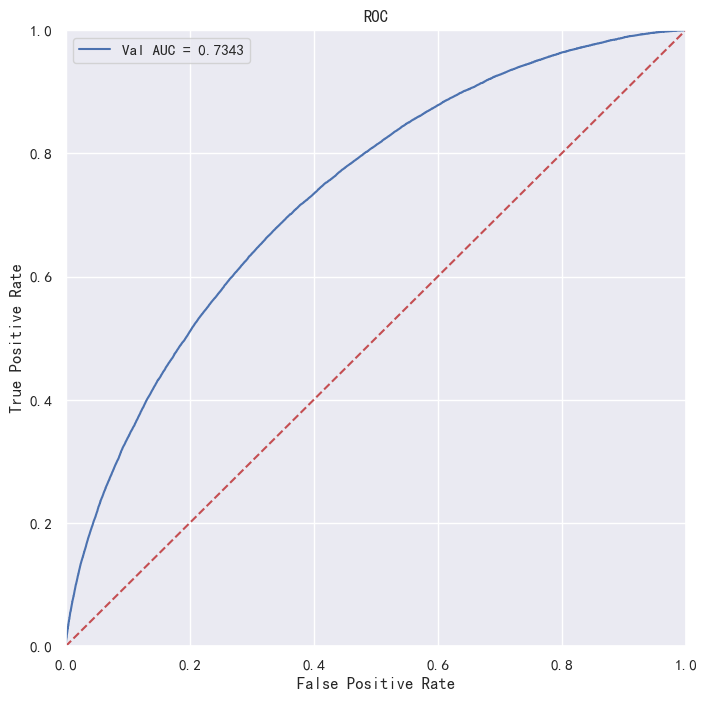

In [87]:
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 14,
                    'max_depth': 19,
                    'min_data_in_leaf': 37,
                    'min_child_weight':1.6,
                    'bagging_fraction': 0.98,
                    'feature_fraction': 0.69,
                    'bagging_freq': 96,
                    'reg_lambda': 9,
                    'reg_alpha': 7,
                    'min_split_gain': 0.4,
                    'nthread': 8,
                    'seed': 2023,
}

train_x,valid_x,train_y,valid_y = train_test_split(train_features,train_label,test_size=0.2)
train_matrix = lgb.Dataset(train_x,label=train_y)
valid_matrix = lgb.Dataset(valid_x,label=valid_y)
final_model_lgb = lgb.train(base_params_lgb, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=6000, verbose_eval=1000, early_stopping_rounds=200)

"""预测并计算roc的相关指标"""
valid_predict = final_model_lgb.predict(valid_x)
fpr, tpr, threshold = roc_curve(valid_y, valid_predict)
roc_auc = auc(fpr, tpr)
print(f'调参后lightgbm单模型在验证集上的AUC:{format(roc_auc)}')
plt.figure(figsize=(8, 8))
plt.title('Validation ROC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.4f' % roc_auc)
plt.ylim(0,1)
plt.xlim(0,1)
plt.legend(loc='best')
plt.title('ROC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# 画出对角线
plt.plot([0,1],[0,1],'r--')
plt.show()